In [207]:
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.model_selection import StratifiedKFold, KFold

from sklearn import metrics
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

## Training functions

In [208]:
def Filter_low_Expr(arr):
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data, selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map):
    array_list = []
    new_id_list = []
    print("House keeping genes:")
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            #print(gene2 + ":" + gene1)
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    print("Regulators:")
    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            if gene2 in dic_gene_map and gene2 in input_data.index:
                #print(gene2 + ":" + gene1)
                
                #cur_regulators_ids.append(dic_gene_map[i])
                new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
                new_arr_bi = []
                for i in new_arr:
                    if i > 0:
                        new_arr_bi.append(1)
                    else:
                        new_arr_bi.append(0)
                array_list.append(new_arr_bi)
                new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size):
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features,
                                      model=None, params=None): #modified at 11:46 AM Feb 15
    # TODO: convert this to be regression instead of classification
    if model is None:
        model = xgb.XGBRegressor
        if params is None:
            params = {'n_jobs': 4, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
    else:
        if params is None:
            params = {}
    xgb_model = model(**params)
    
    xgb_model.fit(train_data,train_labels.values)
    
    predictions_train = xgb_model.predict(train_data)

    predictions = xgb_model.predict(test_data)
    
    predictions_independent = xgb_model.predict(independent_features)

    # evaluation metrics: mean_squared_error, mean_absolute_percentage_error, r2_score

    mse_train = mean_squared_error(train_labels, predictions_train)
    mape_train = mean_absolute_percentage_error(train_labels, predictions_train)
    r2_train = r2_score(train_labels, predictions_train)

    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    mse_test = mean_squared_error(test_labels, predictions)
    mape_test = mean_absolute_percentage_error(test_labels, predictions)
    r2_test = r2_score(test_labels, predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    mse_independent = mean_squared_error(independent_labels, predictions_independent)
    mape_independent = mean_absolute_percentage_error(independent_labels, predictions_independent)
    r2_independent = r2_score(independent_labels, predictions_independent)

    result_summary = {}
    #result_summary['random_state'] = random_

    result_summary['train_mse'] = mse_train
    result_summary['train_mape'] = mape_train
    result_summary['train_r2'] = r2_train

    #result_summary['best_params'] = clf.best_params_
    result_summary['test_mse'] = mse_test #1
    result_summary['test_mape'] = mape_test #2
    result_summary['test_r2'] = r2_test #3
    
    result_summary['independent_mse'] = mse_independent #1
    result_summary['independent_mape'] = mape_independent #2
    result_summary['independent_r2'] = r2_independent #3

    if hasattr(xgb_model, 'feature_importances_'):
        result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
        result_feature = result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)
    else:
        result_feature = None
    result_summary['features'] = result_feature
    return(result_summary)


## Loading data

#### The BeatAML wave 1/2 dataset is from the Tyler 2018 paper, and the BeatAML wave 3/4 dataset is from the Cancer Cell 2022 paper. The gene expression values are in general similar, but not exactly the same according to the data processing steps.




In [209]:
#data_all_w12 = pd.read_csv("data/beatAML_wave12_feature_ic50_highExpr_Mar19_2024_w12.csv", index_col= "Unnamed: 0")

# Load all data for beat AML wave 1 to 4 from the 2022 paper
data_all_w14 = pd.read_csv("data/beatAML_wave14_feature_ic50_highExpr_Mar19_2024_w1_4.csv", index_col= "Unnamed: 0")
print("wave 1 to 4 data:")
print(data_all_w14.shape)
print(data_all_w14.columns[0:23]) # Feature set 1 is from column 0 to 23
print(data_all_w14.columns[23:41]) # Feature set 2 is from column 23 to 41
#print(data_all_w14.columns[41:19894]) # Feature set 3 is from column 41 to 19894
#print(data_all_w14.columns[19894:20215]) # Drug response data is from column 19894 to 20215

# Load all data from the beat AML wave 1 to 2 data from the 2018 paper
data_all_w12 = pd.read_csv("data/beatAML_wave12_feature_ic50_highExpr_Apr30_2024_w12.csv", index_col= "Unnamed: 0")
print("wave 1 to 2 data:")
print(data_all_w12.shape)
print(data_all_w12.columns[0:22])
print(data_all_w12.columns[22:40])
#print(data_all_w12.columns[40:17731])
#print(data_all_w12.columns[17731:17853])

wave 1 to 4 data:
(969, 20215)
Index(['FLT3', 'SRSF2', 'CEBPA', 'SF3B1', 'NPM1', 'KRAS', 'RUNX1', 'DNMT3A',
       'ASXL1', 'IDH2', 'PTPN11', 'JAK2', 'PDS5B', 'STAG2', 'IDH1', 'BCOR',
       'TET2', 'GATA2', 'U2AF1', 'EZH2', 'WT1', 'NRAS', 'TP53'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140', 'IDH2:p.R172', 'JAK2:p.V617', 'KIT:p.D816',
       'KRAS:p.G12/13', 'NPM1:p.W288-90', 'NRAS:p.G12/13', 'NRAS:p.Q61',
       'SF3B1:p.K700E', 'SF3B1:p.K666', 'SRSF2:p.94-95', 'U2AF1:p.S34',
       'U2AF1:p.156-157', 'ZNF687:p.R939Pfs*36:151262327'],
      dtype='object')
wave 1 to 2 data:
(783, 17853)
Index(['EZH2', 'DNMT3A', 'BCOR', 'SF3B1', 'TET2', 'KRAS', 'U2AF1', 'CEBPA',
       'NPM1', 'GATA2', 'PTPN11', 'IDH2', 'NRAS', 'ASXL1', 'RUNX1', 'JAK2',
       'FLT3', 'WT1', 'STAG2', 'TP53', 'IDH1', 'SRSF2'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140'

#### Theare are 672 samples from the Beat AML wave 1/2 and 297 samples from wave 3/4


In [210]:
w12_shared_samples = list(set(data_all_w12.index).intersection(set(data_all_w14.index)))
print(len(w12_shared_samples))

w34_samples = list(set(data_all_w14.index) - set(w12_shared_samples))
print(len(w34_samples))

672
297


In [211]:
data_all_w12.shape

(783, 17853)

In [212]:

# Load testing data from BeatAML wave 3 and 4
BeatAML_wave_3_expr = pd.read_csv("data/beataml_waves1to4_allnorm.txt.gz", sep = "\t") 
BeatAML_wave_3_drugResponse = pd.read_csv("data/beataml_probit_curve_fits_v4_distr_nonproprietary.txt.gz", sep = "\t")

# read xlsx file
#BeatAML_all_clinic = pd.read_excel("data/beataml_wv1to4_clinical_summary_01_22_2021.xlsx")


In [213]:
BeatAML_wave_3_drugResponse.columns

Index(['lab_id', 'patient_id', 'inhibitor', 'min_conc', 'max_conc',
       'intercept', 'beta', 'beta_z', 'beta_p', 'aic', 'pearson_chisq',
       'deviance', 'converged', 'ic10', 'ic25', 'ic50', 'ic75', 'ic90', 'auc',
       'all_gt_50', 'all_lt_50', 'curve_type', 'type', 'proprietary'],
      dtype='object')

In [214]:
BeatAML_wave_3_drugResponse.index = pd.MultiIndex.from_arrays([BeatAML_wave_3_drugResponse.lab_id, BeatAML_wave_3_drugResponse.inhibitor])

### Adding AUC data for all drugs

In [216]:
# TODO: add columns to data_all_w14 and data_all_w12 for the drug AUC for all drugs.
patient_drugs_auc = {}
for i, row in data_all_w14.iterrows():
    patient_auc = {}
    for drug in data_all_w14.columns[19894:20215]:
        try:
            patient_auc[drug + '_auc'] = BeatAML_wave_3_drugResponse.loc[(i, drug), 'auc']
        except KeyError:
            continue
    patient_drugs_auc[i] = patient_auc

patient_drugs_auc_w12 = {}
for i, row in data_all_w12.iterrows():
    patient_auc = {}
    for drug in data_all_w12.columns[17731:17853]:
        try:
            patient_auc[drug + '_auc'] = BeatAML_wave_3_drugResponse.loc[(i, drug), 'auc']
        except KeyError:
            continue
    patient_drugs_auc_w12[i] = patient_auc

In [217]:
patient_drugs_auc = pd.DataFrame(patient_drugs_auc).T
patient_drugs_auc_w12 = pd.DataFrame(patient_drugs_auc_w12).T

In [219]:
data_all_w14 = pd.concat([data_all_w14, patient_drugs_auc], axis=1)
data_all_w14

,FLT3,SRSF2,CEBPA,SF3B1,NPM1,KRAS,RUNX1,DNMT3A,ASXL1,IDH2,...,PD98059_auc,PD153035_auc,R547_auc,R406_auc,MEK1/2 Inhibitor_auc,Everolimus_auc,AKT Inhibitor X_auc,PRT062070_auc,AST-487_auc,SU14813_auc
11-00178,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17-00066,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18-00208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15-00626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15-00357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13-00316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16-00541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16-00524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12-00301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
data_all_w12 = pd.concat([data_all_w12, patient_drugs_auc_w12], axis=1)
data_all_w12

,EZH2,DNMT3A,BCOR,SF3B1,TET2,KRAS,U2AF1,CEBPA,NPM1,GATA2,...,Entospletinib (GS-9973)_auc,Linifanib (ABT-869)_auc,NVP-ADW742_auc,Lenalidomide_auc,Nutlin 3a_auc,Lenvatinib_auc,TG100-115_auc,Volasertib (BI-6727)_auc,Ruxolitinib (INCB018424)_auc,Crenolanib_auc
14-00359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16-00867,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,121.530149,170.212221,105.128902,80.927174,273.178351,124.250679,226.460228,103.654599,NaN,NaN
13-00602,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,182.196412,222.667803,NaN,NaN,NaN,243.212659,NaN,186.065714,266.898220
15-00302,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,262.600099,210.351498,202.644853,NaN,251.613839,200.337986,249.389303,163.109627,259.536301,243.871620
13-00454,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,226.443072,267.823353,NaN,NaN,NaN,286.327943,NaN,286.327943,226.856804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15-00938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17-00216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16-00526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16-01011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Processing sample indices

In [221]:
BeatAML_w12_samples = set(data_all_w12.index).intersection(set(data_all_w14.index))
print(len(BeatAML_w12_samples))


672


In [222]:
BeatAML_w34_samples = set(data_all_w14.index) - BeatAML_w12_samples
BeatAML_w12_samples = set(data_all_w14.index).intersection(BeatAML_w12_samples)

print(len(BeatAML_w12_samples))
print(len(BeatAML_w34_samples))

672
297


In [223]:
BeatAML_w12_data = data_all_w12.loc[list(BeatAML_w12_samples)]  # This is important to make sure which dataset is used for beatAML wave 1/2
BeatAML_w34_data = data_all_w14.loc[list(BeatAML_w34_samples)]

In [224]:
print(BeatAML_w12_data.shape)
print(BeatAML_w34_data.shape)

(672, 17973)
(297, 20536)


In [225]:
BeatAML_w12_data_set1 = BeatAML_w12_data.columns[0:22]
BeatAML_w12_data_set2 = BeatAML_w12_data.columns[22:40]
BeatAML_w12_data_set3 = BeatAML_w12_data.columns[40:40+17691]


BeatAML_w34_data_set1 = BeatAML_w34_data.columns[0:23]
BeatAML_w34_data_set2 = BeatAML_w34_data.columns[23:41]
BeatAML_w34_data_set3 = BeatAML_w34_data.columns[41:41+19853]

featureset_1 = list(set(BeatAML_w12_data_set1).intersection(set(BeatAML_w34_data_set1)))
featureset_2 = list(set(BeatAML_w12_data_set2).intersection(set(BeatAML_w34_data_set2)))
featureset_3 = list(set(BeatAML_w12_data_set3).intersection(set(BeatAML_w34_data_set3)))

print([len(featureset_1), len(featureset_2), len(featureset_3)])

[22, 18, 17685]


In [226]:
BeatAML_w12_data_set3_df = BeatAML_w12_data[featureset_3]
BeatAML_w12_data_set3_df_t = BeatAML_w12_data_set3_df.transpose()
print(BeatAML_w12_data_set3_df_t.shape)
BeatAML_w12_data_set3_df_t.head(4)

(17685, 672)


,16-00094,16-00533,12-00150,14-00061,14-00476,16-00981,15-00417,14-00473,16-01004,14-00273,...,15-00858,14-00180,13-00625,16-01191,16-01010,15-00909,16-00519,13-00513,14-00542,14-00798
ENSG00000116918,5.241544,NaN,6.247960,6.022694,5.231849,NaN,4.748917,5.151250,5.749562,NaN,...,4.093583,NaN,4.425932,4.840610,4.001918,5.436100,4.992701,5.397719,4.659582,5.569196
ENSG00000259943,4.572609,NaN,4.230834,3.330238,3.923792,NaN,2.059234,4.871109,3.050183,NaN,...,4.075204,NaN,2.762670,4.290717,4.813993,4.497427,4.146136,3.650255,4.015077,3.761633
ENSG00000250317,5.171520,NaN,5.677739,5.608322,5.159408,NaN,5.429578,4.405480,5.407331,NaN,...,4.650379,NaN,5.305609,4.891720,5.466481,5.059344,4.822493,5.502289,5.244416,4.865866
ENSG00000271852,1.401104,NaN,0.374629,1.397935,1.747647,NaN,-0.703401,-1.098897,1.619544,NaN,...,-0.502477,NaN,1.967570,-1.722868,-0.204121,1.756045,0.826824,1.036588,0.066617,-0.181749


In [227]:
BeatAML_w34_data_set3_df = BeatAML_w34_data[featureset_3]
BeatAML_w34_data_set3_df_t = BeatAML_w34_data_set3_df.transpose()
print(BeatAML_w34_data_set3_df_t.shape)
BeatAML_w34_data_set3_df_t.head(4)


(17685, 297)


,17-00963,18-00208,17-00256,18-00223,17-00908,17-00838,18-00238,17-00011,17-00048,19-00025,...,00-00015,17-01023,17-01117,00-00004,17-00326,00-00005,17-00368,19-00092,13-00126,17-00857
ENSG00000116918,5.527979,5.887300,5.654664,6.607494,7.126822,6.822865,6.331795,5.795903,5.971143,5.381873,...,5.203703,6.778073,5.492302,5.322732,5.172698,5.255691,5.857087,5.282756,5.717348,5.695918
ENSG00000259943,5.880182,5.451081,4.562843,5.745362,6.509814,5.059006,4.694381,5.897264,4.031779,6.163567,...,4.795975,5.629929,5.965515,5.146646,6.012784,5.250028,4.896769,5.316010,5.028731,4.513668
ENSG00000250317,6.498122,7.056581,5.671896,6.774510,5.808357,6.491796,6.238326,5.942010,5.585238,6.953208,...,5.784468,6.190037,6.368464,5.839301,6.202581,5.832911,6.131257,6.585041,6.322645,5.890142
ENSG00000271852,1.409863,0.788887,1.544358,0.302041,0.185501,-1.533412,1.965067,-1.013507,0.520583,2.087955,...,2.287390,-0.862427,1.587465,1.599082,2.012894,1.301155,1.336574,1.762720,1.942644,1.481919


## Processing features

In [228]:
Data_dir = "data/"
GE = pd.read_csv(Data_dir + "RPKM.csv.gz",index_col = "Unnamed: 0")

#Formating gene expression data for training data
GE.index = GE['Gene']

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]

In [229]:
#Load features from features that predict drug response, regulatory graph and house keeping genes
#sele_house_keeping =  ["GPS2", "RPS10","ZNF91","FNTA","PSMC1","GPS1","MLH1","ARAF","SF3B2","PSMD2","SRP14","GNB1","HNRNPK","ARF1","RPS11"]
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']
#KG_expr_resp = pd.read_csv("./data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_expr_resp = pd.read_csv("data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
#KG_reg = pd.read_csv("data/KG_regulatory_graph_Mar1_2023.csv")
KG_reg = pd.read_csv("data/KG_regulatory_graph_Mar11_2024.csv")


In [230]:
# Feature selection: Selection of first neighbors
#Drug = "JQ1"
#Drug = "Trametinib (GSK1120212)"
#Drug = "Selumetinib (AZD6244)"
Drug = "Venetoclax"
#Drug = "Vandetanib (ZD6474)"
#Drug = "Idelalisib"


res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
res1 = res1.sort_values(by = ['coef'])
predictors = list(res1['Gene'])
predictors.remove(Drug+"_RSS")
predictors.remove(Drug+"_intercept")


# Selection of the second neighbors
res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
res2 = res2.loc[res2['Coef'] <0]

selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
selected_genes.remove(Drug+"_RSS")
selected_genes.remove(Drug+"_intercept")



print(len(selected_genes))
print(selected_genes)



44
['CLASP1', 'HDAC5', 'CLIP4', 'NPC2', 'ACOT9', 'UBE2M', 'LILRB2', 'DPF2', 'ECHDC3', 'GDF11', 'MYO7A', 'FGD4', 'PAM', 'VENTX', 'ADPRHL1', 'SPICE1', 'NIPBL', 'SUN1', 'RFNG', 'CD14', 'LILRA3', 'MTSS1', 'BCL2', 'C1QA', 'GOLGA8J', 'LINC00471', 'PLA2G6', 'ZNF502', 'IGF2R', 'ZNF517', 'CASC10', 'RP1-257A7.4', 'AC138623.1', 'CNOT7P1', 'RP11-108L7.4', 'CDK2AP2P2', 'PDXP', 'EEF1GP2', 'CTD-3203P2.1', 'RP11-83N9.5', 'SMC5-AS1', 'ZSCAN16-AS1', 'RP11-355B11.2', 'CASC15']


In [231]:
# Formating house keeping gene ids
sele_house_keeping_id = []
selected_genes_id = []

for g in selected_genes:
    selected_genes_id.append(dic_gene_map[g])
    
for g in sele_house_keeping:
    if g in dic_gene_map:
        sele_house_keeping_id.append(dic_gene_map[g])

In [232]:
# drop columns with missing values
training_data_beatAML_wave1_2 = BeatAML_w12_data_set3_df_t.dropna(axis=1)
test_data_beatAML_wave3_4 = BeatAML_w34_data_set3_df_t.dropna(axis=1)

In [233]:
new_feature_df_t = formating_relative_expression(training_data_beatAML_wave1_2,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

new_feature_df_test = formating_relative_expression(test_data_beatAML_wave3_4,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

House keeping genes:
Regulators:
House keeping genes:
Regulators:


In [234]:
# New added function to filter features 
# features for the relative gene expression data in Beat AML wave 1 and 2
print(new_feature_df_t.shape[0])

new_feature_df_t_filter_low = new_feature_df_t.loc[:,new_feature_df_t.sum(axis = 0) > 0.05*new_feature_df_t.shape[0]]
print(new_feature_df_t_filter_low.shape) # filter features with with more than 5% of the samples have non-zero values
new_feature_df_test_filter_high = new_feature_df_t_filter_low.loc[:,new_feature_df_t_filter_low.sum(axis = 0) < 0.95*new_feature_df_t.shape[0]]
print(new_feature_df_test_filter_high.shape) # filter features with with less than 95% of the samples have 1 values

new_feature_df_t = new_feature_df_test_filter_high  # Relative gene expression feature for wave 1 and 2

# features for the relative gene expression data in Beat AML wave 3 and 4

new_feature_df_test = new_feature_df_test.loc[:,new_feature_df_t.columns] # Relative gene expression feature for wave 3 and 4

print(new_feature_df_test.shape)
print(new_feature_df_t.shape)

451
(451, 273)
(451, 232)
(241, 232)
(451, 232)


In [235]:
w12_f123 = BeatAML_w12_data.loc[:,featureset_1 + featureset_2 + featureset_3]
w12_drug = BeatAML_w12_data.loc[:,[Drug, Drug+'_auc']]
df_sele_w12 = pd.concat([ w12_f123,new_feature_df_t,w12_drug],axis = 1)

w34_f123 = BeatAML_w34_data.loc[:,featureset_1 + featureset_2 + featureset_3]
w34_drug = BeatAML_w34_data.loc[:,[Drug, Drug+'_auc']]
df_sele_w34 = pd.concat([ w34_f123,new_feature_df_test,w34_drug],axis = 1)

print(df_sele_w12.shape)
print(df_sele_w34.shape)



(672, 17959)
(297, 17959)


In [236]:
BeatAML_w12_data_set4 = list(new_feature_df_t.columns)
BeatAML_w34_data_set4 = list(new_feature_df_test.columns)
print(len(BeatAML_w34_data_set4))
print(len(BeatAML_w12_data_set4))

232
232


In [241]:
#set1 = list(df_sele_w34.columns[0:23])
#set2 = list(df_sele_w34.columns[23:40])
#set3 = list(df_sele_w34.columns[41:41+19853]) 
set4 = BeatAML_w34_data_set4
set1 = featureset_1 
set2 = featureset_2 
set3 = featureset_3

dic_dataset_test = {
    "Mut": df_sele_w34[set1 + [Drug, Drug+'_auc']].dropna(),
    "VAF": df_sele_w34[set2 + [Drug, Drug+'_auc']].dropna(),
    "Expr": pd.concat([df_sele_w34[set3], df_sele_w34[[Drug, Drug+'_auc']]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w34[set4 + [Drug, Drug+'_auc']].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[[Drug, Drug+'_auc']]], axis = 1).dropna(),
    "Mut+RelativeExpr": df_sele_w34[set1+ set4 + [Drug, Drug+'_auc']].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[set4], df_sele_w34[[Drug, Drug+'_auc']]], axis = 1).dropna(),
}

dic_dataset_train = {
    "Mut": df_sele_w12[set1 + [Drug, Drug+'_auc']].dropna(),
    "VAF": df_sele_w12[set2 + [Drug, Drug+'_auc']].dropna(),
    "Expr": pd.concat([df_sele_w12[set3], df_sele_w12[[Drug, Drug+'_auc']]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w12[set4 + [Drug, Drug+'_auc']].dropna(),
    "Mut+VAF": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[[Drug, Drug+'_auc']]], axis = 1).dropna(),
    "Mut+RelativeExpr": df_sele_w12[set1+ set4 + [Drug, Drug+'_auc']].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[set4], df_sele_w12[[Drug, Drug+'_auc']]], axis = 1).dropna()
    }


## Formatting training/testing labels

In [245]:
# get drugs - which drugs are we using? everything in the thresholds table.
thresholds = pd.read_csv('data/selected_threshold_Apr22_2024.csv', index_col=0)
all_drugs = thresholds.Drug

In [246]:
# TODO: just use raw ic50 and AUC?
print(all_drugs.to_list())

['Idelalisib', 'JQ1', 'Pazopanib (GW786034)', 'GDC-0941', '17-AAG (Tanespimycin)', 'Elesclomol', 'Venetoclax', 'Vandetanib (ZD6474)', 'Ponatinib (AP24534)', 'Vatalanib (PTK787)', 'Rapamycin', 'Dasatinib', 'Midostaurin', 'Neratinib (HKI-272)', 'Quizartinib (AC220)', 'Bortezomib (Velcade)', 'Flavopiridol', 'Cediranib (AZD2171)', 'Bosutinib (SKI-606)', 'Crenolanib', 'CYT387', 'KI20227', 'Vargetef', 'Tivozanib (AV-951)', 'Selinexor', 'Linifanib (ABT-869)', 'RAF265 (CHIR-265)', 'Tofacitinib (CP-690550)', 'Foretinib (XL880)', 'PP242', 'AZD1480', 'Cabozantinib', 'PI-103', 'BEZ235', 'Panobinostat', 'INK-128', 'JNJ-28312141', 'PD173955', 'JAK Inhibitor I', 'Axitinib (AG-013736)', 'CI-1040 (PD184352)', 'Doramapimod (BIRB 796)', 'VX-745', 'Trametinib (GSK1120212)', 'Masitinib (AB-1010)', 'NVP-TAE684', 'KW-2449', 'A-674563', 'Pelitinib (EKB-569)', 'PRT062607', 'Sorafenib', 'SNS-032 (BMS-387032)', 'GSK-1838705A', 'AT7519', 'MGCD-265', 'Dovitinib (CHIR-258)', 'MK-2206', 'Selumetinib (AZD6244)', 'Sun

## Running tests

Axes along which we're doing the analysis:

1. drugs (currently just venetoclax)
2. methods (XGBoost regression, LASSOCV, kernel ridge regression (KRR))
3. targets (AUC, IC50)
4. feature sets (Mut, Expr, RelativeExpr, Mut+RelativeExpr)
5. Cross-validation folds

In [247]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.kernel_ridge import KernelRidge

In [286]:
def run_regression_dataset(dataset, dic_dataset_train, dic_dataset_test, drug='Venetoclax', method='XGBoost', target='auc',
                          model_kwargs=None):
    """
    Runs 10-fold CV for a given drug, method, target, and feature set combo.
    """
    print(dataset)
    if method == 'XGBoost':
        model = xgb.XGBRegressor
    elif method == 'LassoCV':
        model = LassoCV
        if model_kwargs is None:
            model_kwargs = {'selection': 'random', 'tol': 1e-3, 'n_jobs': 2}
    elif method == 'Lasso':
        model = Lasso
    elif method == 'KernelRidge':
        model = KernelRidge
        if model_kwargs is None:
            model_kwargs = {'kernel': 'rbf', }
            if dataset == 'Expr':
                model_kwargs['alpha'] = 0.1
                model_kwargs['gamma'] = 1e-5
    data_cur_train = dic_dataset_train[dataset]
    data_cur_train = data_cur_train.dropna()

    data_cur_test = dic_dataset_test[dataset][data_cur_train.columns]
    data_cur_test = data_cur_test.dropna()

    # TODO: get AUC as well?
    result_all = {}

    X = data_cur_train.iloc[:, :-2]
    if target == 'ic50':
        y = data_cur_train.loc[:, drug]
        y_indep = data_cur_test.loc[:, drug]
    elif target == 'auc':
        y = data_cur_train.loc[:, drug+'_auc']
        y_indep = data_cur_test.loc[:, drug+'_auc']
    X_indep = data_cur_test.iloc[:,:-2]
        
    kfold = KFold(n_splits=10)
    splits = kfold.split(X, y)

    for i, (train_indices, test_indices) in enumerate(splits):
        print('fold:', i)

        train_data = X.iloc[train_indices]
        test_data = X.iloc[test_indices]

        train_labels = y.iloc[train_indices]
        test_labels = y.iloc[test_indices]
        t = time.time()
        result_all[i] = model_run_with_Independent_testSet(train_data,
                                                              test_data, 
                                                              train_labels, 
                                                              test_labels, 
                                                              y_indep,  
                                                              X_indep,
                                                          model=model,
                                                          params=model_kwargs)
        print('train_r2:', result_all[i]['train_r2'], 'test_r2:', result_all[i]['test_r2'],
              'independent_r2:', result_all[i]['independent_r2'], 'runtime:', time.time() - t)
        result_all[i]['runtime'] = time.time() - t
    return result_all

### Hyperparameter tuning for kernel ridge regression on gene expression data

In [266]:
import itertools
feature_sets = ['Expr']
methods = ['KernelRidge']
targets = ['auc']
# TODO: rbf kernel bandwith? median
alpha_vals = [1e-3, 1e-2, 1e-1, 1, 10]
gam_vals = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
results_vals = {}
for dataset, method, target, alpha_val, gam_val in itertools.product(feature_sets, methods, targets, alpha_vals, gam_vals):
    print(alpha_val, gam_val)
    result_all = run_regression_dataset(dataset, dic_dataset_train, dic_dataset_train, method=method, target=target,
                                       model_kwargs={'kernel': 'rbf', 'alpha':alpha_val, 'gamma': gam_val})
    results_vals[alpha_val, gam_val] = result_all

0.001 1e-06
Expr
fold: 0
train_r2: 0.9973868711932986 test_r2: 0.3199069609674573 independent_r2: 0.9403130768460789 runtime: 2.535348892211914
fold: 1
train_r2: 0.9972062311709261 test_r2: 0.6801617787873158 independent_r2: 0.9639688914610457 runtime: 1.9499623775482178
fold: 2
train_r2: 0.9972092291215474 test_r2: 0.7416748963768485 independent_r2: 0.975384049812695 runtime: 2.8780786991119385
fold: 3
train_r2: 0.9975016621521886 test_r2: 0.3625562326463203 independent_r2: 0.9600470735742347 runtime: 2.692117214202881
fold: 4
train_r2: 0.9975469823109459 test_r2: 0.5763439271078258 independent_r2: 0.9577353761539086 runtime: 1.8797328472137451
fold: 5
train_r2: 0.9973275142640408 test_r2: 0.49400926661426703 independent_r2: 0.9631815097728874 runtime: 2.3505237102508545
fold: 6
train_r2: 0.997635894180863 test_r2: 0.4165620679682732 independent_r2: 0.9470636592718319 runtime: 3.083024501800537
fold: 7
train_r2: 0.9972919453435617 test_r2: 0.4931844510313057 independent_r2: 0.93633152

In [272]:
# figure out the best hyperparameters for both expr and relativeexpr
mean_test_r2 = {k: np.mean([x['test_r2'] for iter, x in row.items()]) for k, row in results_vals.items()}

In [281]:
sorted(list(mean_test_r2.items()), key=lambda x: x[1])[::-1]

[((0.1, 1e-05), 0.5517300498323034),
 ((0.01, 1e-06), 0.5456347752765717),
 ((0.1, 1e-06), 0.5378786096943446),
 ((1, 1e-05), 0.5258273301697665),
 ((0.01, 1e-05), 0.5237893209008141),
 ((0.001, 1e-05), 0.5160553172933262),
 ((0.001, 1e-06), 0.4990796909102113),
 ((1, 1e-06), 0.35184506248238695),
 ((10, 1e-05), 0.2609494635714865),
 ((10, 1e-06), 0.038810564550678474),
 ((0.001, 0.0001), -0.1278957195630009),
 ((0.01, 0.0001), -0.13258142242417942),
 ((0.1, 0.0001), -0.1792121015123984),
 ((1, 0.0001), -0.6135968231156816),
 ((10, 0.0001), -2.8070381221132013),
 ((0.001, 0.001), -5.166675933634637),
 ((0.01, 0.001), -5.166678630405615),
 ((0.1, 0.001), -5.16670318293726),
 ((1, 0.001), -5.1668275012325235),
 ((10, 0.001), -5.1669523671156385),
 ((10, 1), -5.166980189453465),
 ((10, 0.1), -5.166980189453465),
 ((10, 0.01), -5.166980189453465),
 ((1, 1), -5.166980189453465),
 ((1, 0.1), -5.166980189453465),
 ((1, 0.01), -5.166980189453465),
 ((0.1, 1), -5.166980189453465),
 ((0.1, 0.1),

In [274]:
import itertools
feature_sets = ['RelativeExpr']
methods = ['KernelRidge']
targets = ['auc']
# TODO: rbf kernel bandwith? median
alpha_vals = [1e-3, 1e-2, 1e-1, 1, 10]
gam_vals = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
results_vals_rel = {}
for dataset, method, target, alpha_val, gam_val in itertools.product(feature_sets, methods, targets, alpha_vals, gam_vals):
    print(alpha_val, gam_val)
    result_all = run_regression_dataset(dataset, dic_dataset_train, dic_dataset_train, method=method, target=target,
                                       model_kwargs={'kernel': 'rbf', 'alpha':alpha_val, 'gamma': gam_val})
    results_vals_rel[alpha_val, gam_val] = result_all

0.001 1e-06
RelativeExpr
fold: 0
train_r2: 0.6502416536078504 test_r2: 0.36988879720936463 independent_r2: 0.6283322060763985 runtime: 0.06204342842102051
fold: 1
train_r2: 0.6081567588630349 test_r2: 0.725360243625043 independent_r2: 0.6220917018241698 runtime: 0.06093096733093262
fold: 2
train_r2: 0.6224907888749303 test_r2: 0.6635912493018163 independent_r2: 0.6260121824419556 runtime: 0.08225131034851074
fold: 3
train_r2: 0.6283146028009617 test_r2: 0.5588015505599313 independent_r2: 0.6268891421922506 runtime: 0.04103565216064453
fold: 4
train_r2: 0.6209384071414801 test_r2: 0.6540312624824144 independent_r2: 0.6250223363798262 runtime: 0.042041778564453125
fold: 5
train_r2: 0.6331287586648247 test_r2: 0.6159642700231764 independent_r2: 0.6320913612259557 runtime: 0.04124021530151367
fold: 6
train_r2: 0.6168109592557179 test_r2: 0.6754589165480924 independent_r2: 0.6236389719578417 runtime: 0.04284405708312988
fold: 7
train_r2: 0.6341434616311314 test_r2: 0.5066918335826314 indepe

In [275]:
mean_test_r2_rel = {k: np.mean([x['test_r2'] for iter, x in row.items()]) for k, row in results_vals_rel.items()}

In [280]:
sorted(list(mean_test_r2_rel.items()), key=lambda x: x[1])[::-1]

[((0.001, 1e-05), 0.6561645415743705),
 ((0.01, 0.0001), 0.6561212853376683),
 ((0.1, 0.001), 0.6556021992189003),
 ((1, 0.01), 0.6434010161790943),
 ((0.1, 0.01), 0.6425487401340026),
 ((0.01, 0.01), 0.6276400754953211),
 ((0.001, 0.01), 0.6247678347984345),
 ((0.01, 0.001), 0.6141797648253172),
 ((0.001, 0.0001), 0.6019722051077785),
 ((0.001, 1e-06), 0.5863325459082701),
 ((0.01, 1e-05), 0.5863063916657675),
 ((0.1, 0.0001), 0.5860386255646483),
 ((1, 0.001), 0.5827096008405048),
 ((0.001, 0.001), 0.5028904334630672),
 ((10, 0.01), 0.4343067044621087),
 ((0.01, 1e-06), 0.22611609173710462),
 ((0.1, 1e-05), 0.22604502033056212),
 ((1, 0.0001), 0.2251627155991438),
 ((10, 0.001), 0.19867949064004678),
 ((1, 1e-05), 0.0017658378333544),
 ((0.1, 1e-06), 0.001389093650904194),
 ((10, 0.0001), -0.009821825480726909),
 ((1, 1e-06), -0.030830519952850178),
 ((10, 1e-05), -0.04183896323372858),
 ((10, 1e-06), -0.04520658821634886),
 ((0.001, 0.1), -2.834001606685836),
 ((0.01, 0.1), -2.84706

For Kernel Ridge regression on gene expression, we use 0.1, 1e-5 as the values for alpha and gamma.

### Run Venetoclax

In [137]:
import itertools

In [288]:
feature_sets = ['Mut', 'VAF', 'Mut+VAF', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr', 'Mut+VAF+RelativeExpr']
methods = ['XGBoost', 'LassoCV', 'KernelRidge']
targets = ['auc', 'ic50']

In [250]:
# TODO: we can use the thresholds solely for balancing our k-fold cross-validations.
# or, we don't use the thresholds at all, and just do 10-fold cross-validation.

import time
regression_results = {}
results_columns = []
for dataset, method, target in itertools.product(feature_sets, methods, targets):
    print(dataset, method, target)
    result_all = run_regression_dataset(dataset, dic_dataset_train, dic_dataset_test, method=method, target=target)
    regression_results[(dataset, method, target)] = result_all

Mut XGBoost auc
Mut
fold: 0
train_r2: 0.6494070356007863 test_r2: -0.26479927109415 independent_r2: -0.38114076250799767 runtime: 0.10109567642211914
fold: 1
train_r2: 0.6403535103931495 test_r2: -0.2469005673667326 independent_r2: -0.3018170082455991 runtime: 0.04544472694396973
fold: 2
train_r2: 0.6357409150853082 test_r2: -0.5127740468563029 independent_r2: -0.32358474249965274 runtime: 0.08223605155944824
fold: 3
train_r2: 0.6526175701589028 test_r2: -0.6437419685935695 independent_r2: -0.4101011711722087 runtime: 0.056340932846069336
fold: 4
train_r2: 0.6467427534228212 test_r2: -0.5601878667739335 independent_r2: -0.31946353075285794 runtime: 0.05835890769958496
fold: 5
train_r2: 0.6519738550478256 test_r2: -0.31807796947482414 independent_r2: -0.29297200786564304 runtime: 0.06537580490112305
fold: 6
train_r2: 0.6407780864214117 test_r2: -0.33945264666702224 independent_r2: -0.3063785952771443 runtime: 0.08284926414489746
fold: 7
train_r2: 0.668997935505319 test_r2: -0.0797682297

In [ ]:
regression_results

# Run every drug

In [290]:
all_drug_regression_results = {}
all_data = pd.read_csv('all_drug_regression_results.csv', index_col=None)
for i, row in all_data.iterrows():
    k = (row.drug, row.feature_set, row.method, row.target)
    if k not in all_drug_regression_results:
        all_drug_regression_results[k] = {}
    row_cols = row.keys()[4:]
    row_dict = {}
    for c in row_cols:
        row_dict[c] = row[c]
    all_drug_regression_results[k][row.iter] = row_dict

In [295]:
feature_sets = ['Mut', 'VAF', 'Mut+VAF', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr', 'Mut+VAF+RelativeExpr']
methods = ['XGBoost', 'LassoCV', 'KernelRidge']
targets = ['auc', 'ic50']

In [ ]:
for drug in all_drugs.to_list():
    print(drug)
    w12_f123 = BeatAML_w12_data.loc[:,featureset_1 + featureset_2 + featureset_3]
    w12_drug = BeatAML_w12_data.loc[:,[drug, drug+'_auc']]
    df_sele_w12 = pd.concat([ w12_f123,new_feature_df_t,w12_drug],axis = 1)

    w34_f123 = BeatAML_w34_data.loc[:,featureset_1 + featureset_2 + featureset_3]
    w34_drug = BeatAML_w34_data.loc[:,[drug, drug+'_auc']]
    df_sele_w34 = pd.concat([ w34_f123,new_feature_df_test,w34_drug],axis = 1)
    
    dic_dataset_test_drug = {
    "Mut": df_sele_w34[set1 + [drug, drug+'_auc']].dropna(),
    "VAF": df_sele_w34[set2 + [drug, drug+'_auc']].dropna(),
    "Mut+VAF": df_sele_w34[set1 + set2 + [drug, drug+'_auc']].dropna(),
    "Expr": df_sele_w34[set3 + [drug, drug+'_auc']].dropna(),
    "RelativeExpr": df_sele_w34[set4 + [drug, drug+'_auc']].dropna(),
    "Mut+RelativeExpr": df_sele_w34[set1+ set4 + [drug, drug+'_auc']].dropna(),
    "Mut+VAF+RelativeExpr": df_sele_w34[set1 + set2 + set4 + [drug, drug+'_auc']].dropna()
    }

    dic_dataset_train_drug = {
    "Mut": df_sele_w12[set1 + [drug, drug+'_auc']].dropna(),
    "VAF": df_sele_w12[set2 + [drug, drug+'_auc']].dropna(),
    "Mut+VAF": df_sele_w12[set1 + set2 + [drug, drug+'_auc']].dropna(),
    "Expr": pd.concat([df_sele_w12[set3], df_sele_w12[[drug, drug+'_auc']]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w12[set4 + [drug, drug+'_auc']].dropna(),
    "Mut+RelativeExpr": df_sele_w12[set1+ set4 + [drug, drug+'_auc']].dropna(),
    "Mut+VAF+RelativeExpr": df_sele_w12[set1 + set2 + set4 + [drug, drug+'_auc']].dropna()
    }
    for dataset, method, target in itertools.product(feature_sets, methods, targets):
        print(drug, dataset, method, target)
        if (drug, dataset, method, target) in all_drug_regression_results and (method != 'KernelRidge' or dataset != 'Expr'):
            old_results = all_drug_regression_results[(drug, dataset, method, target)]
            print('Already ran')
            continue
            for k, v in old_results.items():
                print(k, 'train_r2:', old_results[k]['train_r2'], 'test_r2:', old_results[k]['test_r2'],
                  'independent_r2:', old_results[k]['independent_r2'], 'runtime:', old_results[k]['runtime'])
            continue
        result_all = run_regression_dataset(dataset, dic_dataset_train_drug, dic_dataset_test_drug, method=method, target=target,
                                           drug=drug)
        all_drug_regression_results[(drug, dataset, method, target)] = result_all

In [305]:
results_columns = [x for x in all_drug_regression_results[('Venetoclax', 'Mut', 'XGBoost', 'auc')][0].keys() if x!='features' and x!='iter']
# create a data table for venetoclax only
# columns: drug, method, target, features, run
all_drug_data_table_columns = ['drug', 'feature_set', 'method', 'target', 'iter'] + results_columns
all_drug_data_table = []
for key, results in all_drug_regression_results.items():
    for i, result in results.items():
        row = list(key) + [i]
        for c in results_columns:
            row.append(result[c])
        all_drug_data_table.append(row)
all_drug_data_table = pd.DataFrame(all_drug_data_table)
all_drug_data_table.columns = all_drug_data_table_columns

In [307]:
all_drug_data_table

,drug,feature_set,method,target,iter,train_mse,train_mape,train_r2,test_mse,test_mape,test_r2,independent_mse,independent_mape,independent_r2,runtime
0,Idelalisib,Mut,XGBoost,auc,0,959.992369,0.129452,0.581095,1966.460221,0.203349,-0.318271,3170.229831,0.279143,-0.460721,0.104214
1,Idelalisib,Mut,XGBoost,auc,1,960.930242,0.124880,0.579634,2627.605214,0.260969,-0.721189,3217.808723,0.285678,-0.482643,0.078411
2,Idelalisib,Mut,XGBoost,auc,2,920.367785,0.122378,0.555459,3869.717785,0.982554,-0.188009,3134.253765,0.284423,-0.444144,0.182187
3,Idelalisib,Mut,XGBoost,auc,3,1002.184000,0.130755,0.562346,2523.918806,0.297630,-0.660336,2912.155572,0.269998,-0.341810,0.046575
4,Idelalisib,Mut,XGBoost,auc,4,991.416719,0.130646,0.561705,2991.424357,0.221167,-0.715383,3092.059362,0.279164,-0.424703,0.051976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26455,NF-kB Activation Inhibitor,Mut+VAF+RelativeExpr,KernelRidge,ic50,5,11.180819,23.613386,0.354530,10.623985,0.623880,-0.147664,18.172167,62.690129,0.050743,0.106537
26456,NF-kB Activation Inhibitor,Mut+VAF+RelativeExpr,KernelRidge,ic50,6,10.599231,21.989947,0.360651,17.795076,20.829713,-0.027042,18.845979,65.030530,0.015545,0.115442
26457,NF-kB Activation Inhibitor,Mut+VAF+RelativeExpr,KernelRidge,ic50,7,10.894789,18.777758,0.352143,13.968149,61.220142,0.111303,19.206829,65.067884,-0.003305,0.086179
26458,NF-kB Activation Inhibitor,Mut+VAF+RelativeExpr,KernelRidge,ic50,8,10.932295,19.653808,0.332883,14.994918,52.970202,0.228154,18.846284,65.242372,0.015529,0.077884


In [308]:
all_drug_data_table.to_csv('all_drug_regression_results.csv', index=None)

# Plotting/analyzing results - Venetoclax only

In [140]:
# TODO: plot results for venetoclax only?
results_columns = [x for x in regression_results[('Mut', 'XGBoost', 'auc')][0].keys() if x!='features']
# create a data table for venetoclax only
# columns: drug, method, target, features, run
data_table_columns = ['feature_set', 'method', 'target', 'iter'] + results_columns
data_table = []
for key, results in regression_results.items():
    for i, result in results.items():
        row = list(key) + [i]
        for c in results_columns:
            row.append(result[c])
        data_table.append(row)

In [141]:
data_table = pd.DataFrame(data_table)

In [143]:
data_table.columns = data_table_columns

In [144]:
data_table

,feature_set,method,target,iter,train_mse,train_mape,train_r2,test_mse,test_mape,test_r2,independent_mse,independent_mape,independent_r2,runtime
0,Mut,XGBoost,auc,0,1980.252745,1.210217e+08,0.649407,5223.408409,0.470750,-0.264799,9330.721311,3.689016e+08,-0.381141,0.168936
1,Mut,XGBoost,auc,1,1939.922363,1.200003e+08,0.640354,7275.085786,0.505288,-0.246901,8794.825286,2.822469e+08,-0.301817,0.070691
2,Mut,XGBoost,auc,2,2044.156139,1.178403e+08,0.635741,6472.126192,1.040294,-0.512774,8941.883911,3.171360e+08,-0.323585,0.043169
3,Mut,XGBoost,auc,3,1986.790757,9.751971e+07,0.652618,5646.284841,0.414641,-0.643742,9526.372261,3.676249e+08,-0.410101,0.040309
4,Mut,XGBoost,auc,4,2001.191339,1.128230e+08,0.646743,6571.044965,0.623259,-0.560188,8914.041797,4.004617e+08,-0.319464,0.048337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Mut+RelativeExpr,KernelRidge,ic50,5,8.196746,2.230968e+01,0.616485,14.717264,16.094121,0.316389,10.795857,4.323257e+01,0.441244,0.082189
236,Mut+RelativeExpr,KernelRidge,ic50,6,8.825907,2.382497e+01,0.595680,8.127384,25.845404,0.395887,11.089220,4.736885e+01,0.426061,0.092425
237,Mut+RelativeExpr,KernelRidge,ic50,7,8.282871,2.230021e+01,0.612049,14.029435,14.134227,0.360051,10.745687,4.457547e+01,0.443841,0.089852
238,Mut+RelativeExpr,KernelRidge,ic50,8,8.604582,2.161688e+01,0.599398,10.058312,22.571185,0.526447,10.801636,4.344088e+01,0.440945,0.084736


In [145]:
data_table.to_csv('venetoclax_regression_results_all.csv', index=None)

In [148]:
import seaborn as sns

Text(0.5, 1.0, 'R^2 for AUC on the independent test set')

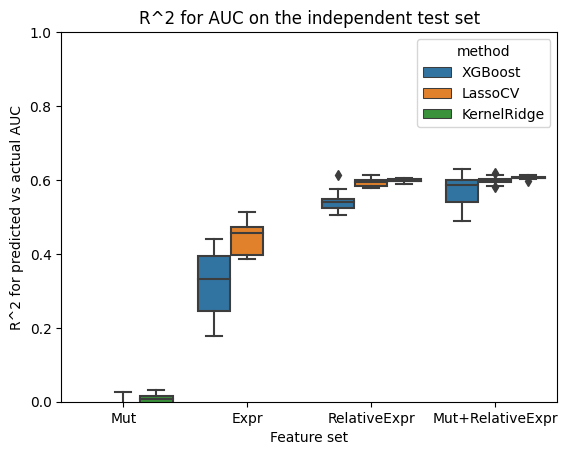

In [160]:
sns.boxplot(data=data_table[(data_table.target=='auc')],
            x='feature_set', y='independent_r2', hue='method')
plt.ylim(0, 1)
plt.xlabel('Feature set')
plt.ylabel('R^2 for predicted vs actual AUC')
plt.title('R^2 for AUC on the independent test set')

Text(0.5, 1.0, 'R^2 for IC50 on the independent test set')

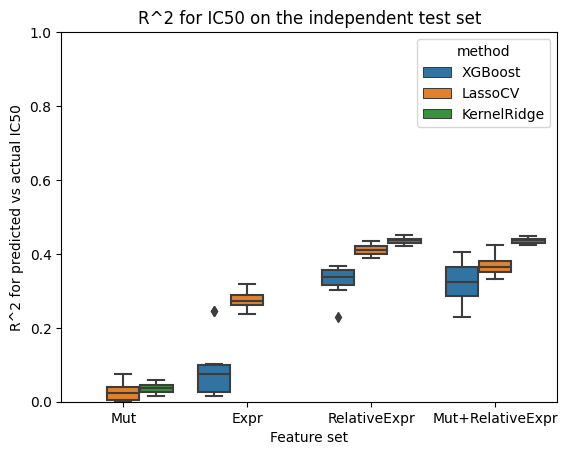

In [161]:
sns.boxplot(data=data_table[(data_table.target=='ic50')],
            x='feature_set', y='independent_r2', hue='method')
plt.ylim(0, 1)
plt.xlabel('Feature set')
plt.ylabel('R^2 for predicted vs actual IC50')
plt.title('R^2 for IC50 on the independent test set')